This notebook provides statistics on the results of our book clustering.


## Setup


In [1]:
library(tidyverse, warn.conflicts=FALSE)
library(arrow, warn.conflicts=FALSE)

I want to use `theme_minimal()` by default:


In [2]:
theme_set(theme_minimal())

And default image sizes aren't great:


In [3]:
options(repr.plot.width  = 7,
        repr.plot.height = 4)

## Load Data

Let's start by getting our clusters and their statistics:


In [4]:
clusters = read_parquet("book-links/cluster-stats.parquet", as_data_frame=FALSE)
glimpse(clusters)

Table
39,732,662 rows x 8 columns
$ cluster        <int32> 423896385, 454491654, 424930878, 449145631, 440372971, …
$ n_nodes       <uint32> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ n_isbns       <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_loc_recs    <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_ol_editions <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_ol_works    <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_gr_books    <uint32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_gr_works    <uint32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…


Describe the count columns for basic descriptive stats:


In [5]:
clusters %>%
  select(-cluster) %>%
  collect() %>%
  summary()

    n_nodes            n_isbns           n_loc_recs        n_ol_editions     
 Min.   :    1.00   Min.   :    0.00   Min.   :   0.0000   Min.   :    0.00  
 1st Qu.:    2.00   1st Qu.:    0.00   1st Qu.:   0.0000   1st Qu.:    1.00  
 Median :    3.00   Median :    1.00   Median :   0.0000   Median :    1.00  
 Mean   :    3.38   Mean   :    1.08   Mean   :   0.2434   Mean   :    1.13  
 3rd Qu.:    4.00   3rd Qu.:    2.00   3rd Qu.:   0.0000   3rd Qu.:    1.00  
 Max.   :99983.00   Max.   :47857.00   Max.   :1560.0000   Max.   :41648.00  
   n_ol_works          n_gr_books         n_gr_works      
 Min.   :   0.0000   Min.   :   0.000   Min.   :  0.0000  
 1st Qu.:   1.0000   1st Qu.:   0.000   1st Qu.:  0.0000  
 Median :   1.0000   Median :   0.000   Median :  0.0000  
 Mean   :   0.8241   Mean   :   0.059   Mean   :  0.0383  
 3rd Qu.:   1.0000   3rd Qu.:   0.000   3rd Qu.:  0.0000  
 Max.   :2368.0000   Max.   :7289.000   Max.   :326.0000  

75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?


In [6]:
src_counts = clusters %>%
  summarize(across(-cluster, ~ sum(.x > 0))) %>%
  collect() %>%
  pivot_longer(everything(), names_to="source", values_to="count")
src_counts

source,count
<chr>,<int>
n_nodes,39732662
n_isbns,23191293
n_loc_recs,9279082
n_ol_editions,33194439
n_ol_works,31327564
n_gr_books,1505314
n_gr_works,1504790


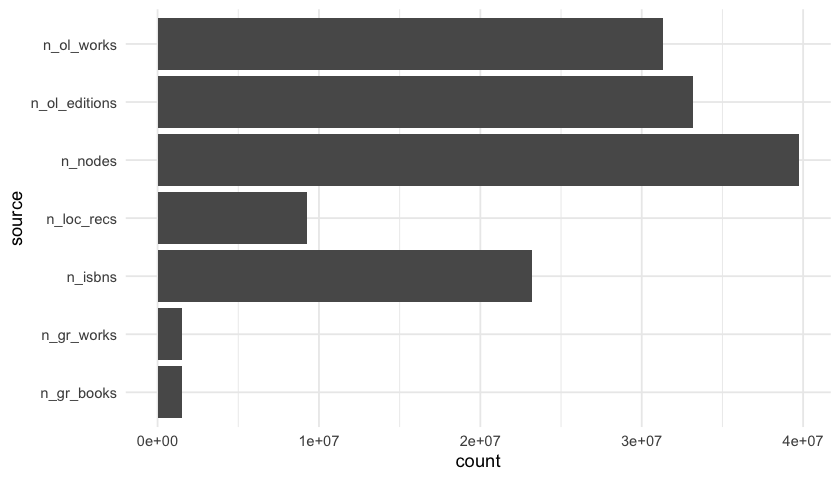

In [7]:
ggplot(src_counts, aes(y=source, x=count)) +
  geom_bar(stat='identity')

## Distributions

Let's look at the distributions of cluster sizes.  Let's first compute histograms
of the number of records per cluster for each cluster type.


In [8]:
size_dists = collect(clusters) %>%
  gather(rec_type, nrecs, -cluster, factor_key=TRUE) %>%
  summarize(count=n(), .by=c("rec_type", "nrecs"))
head(size_dists)

rec_type,nrecs,count
<fct>,<int>,<int>
n_nodes,2,10145355
n_nodes,1,7003440
n_nodes,3,8529247
n_nodes,4,8060278
n_nodes,5,2057072
n_nodes,6,1098443


Warning message:
“Transformation introduced infinite values in continuous x-axis”


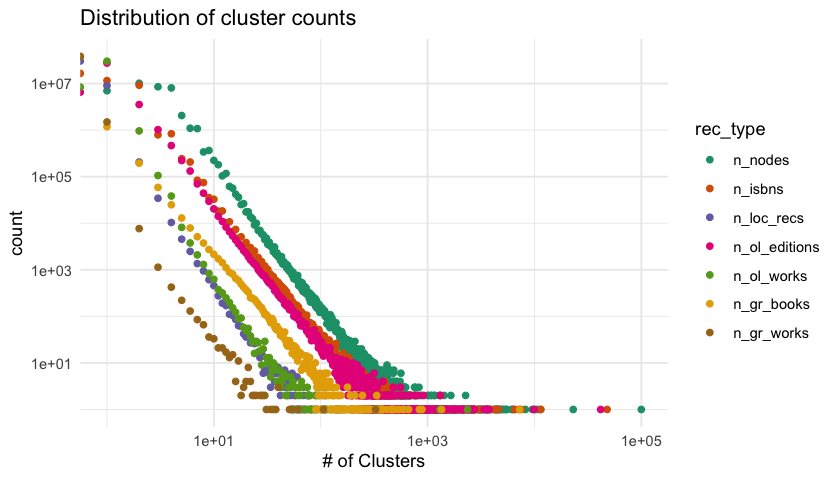

In [9]:
ggplot(size_dists) +
  aes(x=nrecs, y=count, color=rec_type) +
  geom_point() +
  scale_x_log10() +
  scale_y_log10() +
  scale_color_brewer(type="qual", palette="Dark2") +
  xlab("# of Records") +
  xlab("# of Clusters") +
  ggtitle("Distribution of cluster counts")

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

What's going on with these clusters? Let's take a peek at them.


In [10]:
gr_big = clusters %>%
  filter(n_gr_works > 1) %>%
  arrange(desc(n_gr_works))
gr_big %>% glimpse()

Table (query)
9,947 rows x 8 columns
$ cluster        <int32> 100007751, 100121298, 100280224, 100758802, 103061864, …
$ n_nodes       <uint32> 99983, 9562, 513, 1548, 315, 337, 513, 304, 685, 610, 5…
$ n_isbns       <uint32> 47857, 4627, 192, 749, 141, 91, 225, 120, 245, 299, 248…
$ n_loc_recs    <uint32> 1560, 281, 6, 54, 1, 38, 6, 3, 2, 0, 0, 1, 104, 111, 0,…
$ n_ol_editions <uint32> 41648, 3710, 110, 442, 51, 64, 113, 75, 185, 170, 153, …
$ n_ol_works    <uint32> 1303, 323, 75, 80, 18, 58, 38, 21, 75, 45, 47, 25, 190,…
$ n_gr_books    <uint32> 7289, 515, 69, 170, 53, 46, 91, 45, 140, 60, 51, 46, 49…
$ n_gr_works    <uint32> 326, 106, 61, 53, 51, 40, 40, 40, 38, 36, 34, 31, 30, 3…
Call `print()` for query details


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?


In [11]:
nrow(gr_big) / sum(!is.na(clusters$n_gr_books))

Scalar
0.0002503481896078345

Less than 1%. Not bad, but let's look at these largest clusters.


In [12]:
gr_big %>% head() %>% collect()

cluster,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100007751,99983,47857,1560,41648,1303,7289,326
100121298,9562,4627,281,3710,323,515,106
100280224,513,192,6,110,75,69,61
100758802,1548,749,54,442,80,170,53
103061864,315,141,1,51,18,53,51
100017358,337,91,38,64,58,46,40


## Large Cluster Debugging

We have some pretty big clusters:


In [13]:
big = clusters %>% slice_max(n_nodes, n=5, with_ties=FALSE) %>%
  collect()
big

cluster,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100007751,99983,47857,1560,41648,1303,7289,326
100241120,23061,11497,189,9899,95,1353,28
124319853,11281,7520,0,3760,1,0,0
122565397,10678,7118,0,3559,1,0,0
100386149,10118,6518,7,3558,35,0,0


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?


In [14]:
isbns = read_parquet('book-links/all-isbns.parquet', as_data_frame=FALSE)
glimpse(isbns)

Table
42,979,427 rows x 8 columns
$ isbn_id <int32> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…
$ isbn   <string> "0001713353", "0001061240", "0001932349", "0001712799", "00020…
$ AZ18    <int32> 54, 45, 18, 54, 18, 244, 17, 927, 596, 25, 12, 107, 19, 59, 26…
$ LOC     <int32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,…
$ OL      <int32> 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1,…
$ GR      <int32> 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,…
$ BX      <int32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,…
$ AZ14    <int32> 0, 0, 0, 0, 0, 0, 6, 2, 1, 0, 0, 12, 17, 14, 10, 9, 11, 0, 0, …


In [15]:
links = read_parquet("book-links/isbn-clusters.parquet", as_data_frame=FALSE) %>%
  select(isbn_id, cluster)
glimpse(links)

Table (query)
42,979,427 rows x 2 columns
$ isbn_id <int32> 42979427, 42979426, 42979425, 42979424, 42979423, 42979422, 42…
$ cluster <int32> 942979427, 942979426, 942979425, 942979424, 942979423, 9429794…
Call `print()` for query details


Now let's look up data for the largest cluster.


In [16]:
big_id = big$cluster[1]
big_id

[1] 100007751

In [17]:
bl = links %>% filter(cluster == big_id)
bl = semi_join(isbns, bl) %>% arrange(isbn)
bl %>% glimpse()

Table (query)
?? rows x 8 columns
$ isbn_id <int32> 41134263, 41072568, 35505305, 27575974, 18407128, 16866838, 27…
$ isbn   <string> "0000744395", "000074445X", "0001004735", "0001004743", "00010…
$ AZ18    <int32> 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3900, 0…
$ LOC     <int32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,…
$ OL      <int32> 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 3, 1, 1, 1, 2,…
$ GR      <int32> 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,…
$ BX      <int32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,…
$ AZ14    <int32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
Call `print()` for query details


What are the things with the highest record count?


In [18]:
bl %>% collect() %>% rowwise() %>% mutate(
  btot = sum(c_across(!starts_with("isbn")))
) %>% slice_max(btot, n=20)

isbn_id,isbn,AZ18,LOC,OL,GR,BX,AZ14,btot
<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
41134263,0000744395,0,0,0,1,0,0,1
41072568,000074445X,0,0,0,1,0,0,1
35505305,0001004735,0,0,1,0,0,0,1
27575974,0001004743,0,0,1,0,0,0,1
18407128,0001034375,0,0,1,0,0,0,1
16866838,0001046403,0,0,1,0,0,0,1
27702965,0001049283,0,0,1,0,0,0,1
79,0001054783,75,0,1,0,0,0,76
18254793,0001385208,0,0,1,0,0,0,1
